In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import ode

from scipy.optimize import curve_fit

# 1. One cell - Water permeation
We consider a blastocyst, supposed to be composed only of a membrane, with radius $R$ (volume is $V$, surface is $A$) in a water medium. The surrounding environment has ground concentration $c_0(t)$ and external pressure $P_0$. Pressure in the blastocyst is denoted $P_b$. The blastocyst lets water come in through aquaporins, that are passive channels, with permeation constant $\lambda_v$. We denote $\Lambda_v = A.\lambda_v$ (so that $\lambda_v$ is independent from the radius, and $\Lambda_v$ is radius-dependent). The blastocyst contains proteins or macromolecules of unspecified nature (for the moment), with concentration $c_{in} = N/V(t) = 3N / 4\pi R^{3}(t)$.
The general equation describing the volume control of the cell is 
$$ \frac{dV}{dt} = A \lambda_v \left[\Delta \Pi - \Delta P \right]$$
where 
$$\Delta P = \frac{2\gamma}{R} (= P_b - P_0)$$
is the Laplace law, with $\gamma$ the surface tension at the cell membrane, and
$$\Delta \Pi = \mathcal{R}T(c_{in}(t) - c_{out}(t)) $$
is the osmostic pressure, with $\mathcal{R}$ the perfect gaz constant and $T$ the temperature.

Note that of we consider that we start from an equilibrium state at t=0, then there is no volume change
$$\frac{dV_0}{dt} = 0 = 4 \pi \lambda_v R_0^{2} \left[ \mathcal{R}T(c_{in}(0) - c_0) - \frac{2\gamma}{R_0}\right] $$
where $R_0 \equiv R(t=0), c_0 \equiv c_{out}(t=0)$.

Dividing both sides by $c_0$

$$\mathcal{R}T \frac{c_{in}(0) - c_0}{c_0} = \frac{2\gamma}{c_0 R_0}$$
it gives us the required concentration in the blastocyst for the equilibrium :
$$\bar{c}_{in}(0) = \frac{c_{in}(0)}{c_0} = \epsilon + 1 $$
where $\pi_0 = \mathcal{R}Tc_0$, $\epsilon = \frac{2\gamma}{\pi_0 R_0}$. In particular, writing $c_{in}(t) = 3 N_{in} / 4 \pi R^3(t)$, we have for $t=0$
$$N_{in} = c_{in}(0) \frac{4}{3}\pi R^3_{0}$$
Since we assume that there is no exchange of ions, $N_{in}$ is a time-constant.

Also note that, with experimental values, $\epsilon \sim 10^{-3}$ and $\Delta \Pi \sim 10^5$ so actually, the hydrostatic pressure difference is negligible compared to the osmotic pressure difference.

## a. Adimensionalization
In order to integrate numerically the equation, we need to adimensionalize them (ie : find the correct typical values for each variable, so that we end up with a system without units).
### i - Area-independent Permeation coefficient
It reduces to
$$ \frac{dR}{dt} = \lambda_v \left[\mathcal{R}T \left(\frac{3N_{\rm{in}}}{4\pi R(t)^3} - c_{out}(t) \right) - \frac{2\gamma}{R} \right]$$

which gives, after adimensionalization :

$$\frac{d \bar{R}}{dt} = \frac{1}{\tau} \left[ \frac{1+\epsilon}{\bar{R}^3(t)} - \bar{c}_{out}(t) - \frac{\epsilon}{\bar{R}(t)}\right]$$

where $R = \bar{R}.R_0$, $c_{out} = \bar{c}_{out}.c_0$, $\tau = \frac{R_0}{\pi_0\lambda_v}$

### ii - Area-dependent Permeation coefficient
It reduces to
$$ \frac{dR}{dt} = \frac{\lambda_v}{4\pi R(t)^2} \left[\mathcal{R}T \left(\frac{3N_{\rm{in}}}{4\pi R(t)^3} - c_{out}(t) \right) - \frac{2\gamma}{R} \right]$$

which gives, after adimensionalization :

$$\frac{d \bar{R}}{dt} = \frac{T}{\bar{R}^2} \left[ \frac{1+\epsilon}{\bar{R}^3(t)} - \bar{c}_{out}(t) - \frac{\epsilon}{\bar{R}(t)}\right]$$

where $T = \frac{\lambda_v(\bar{R}) \pi_0}{4\pi R_0^3}$.


**NB :** in the following, we will drop the bars over the top of the variables. So $R(t)$ and $c_{out}(t)$ are normalized variables.

## b. Osmotic shock : Model testing

We have two coupled equations, one of which is an ordinary differential equation (ode), that can be solved using scipy built-in function. We assume our system to be in the form

$$\begin{cases}
\frac{dR}{dt} = \frac{1+\epsilon}{R^3(t)} - c_{out}(t) - \frac{\epsilon}{R(t)} \\
c_{out}(t) = \sigma(t ; t_1, t_2) \\
\end{cases}$$
with $\sigma$ a function that can either be a ramp or a step function.

In [2]:
def c(t, t1, t2, cmin, cmax, step_function=True, shock='hypo') :
    """"
    c(t, t1, t2, cmin, cmax, step_function=True, shock='hypo')
    
        A function that reproduces the external concentration behavior.
    
        Parameters
        ----------
        t : float
            Time at which you want the external concentration
        t1 : float
            Time at which the first change happens
        t2 : float
            Time at which the second change happens. Must be greater than t1. In the case of the sigmoide, not useful.
        cmin : float
            Minimal concentration
        cmax :float
            Maximal concentration
        step_function : boolean, optional, default : True
            True if step function, False for ramp
        shock : string, optional, default : 'hypo'
            'hypo' for hypoosmotic shock
            'hyper' for hyperosmotic
            
        Returns
        -------
        c : float
            The external concentration (c_out) at time t.
    """
    if step_function==True :
        if t <= t1 :
            if shock == 'hyper' :
                return cmin
            elif shock == 'hypo' :
                return cmax
            
        elif t >= t1 and t <= t2:
            if shock == 'hyper' :
                return cmax
            elif shock == 'hypo' :
                return cmin
            
        else :
            if shock == 'hyper' :
                return cmax
            elif shock == 'hypo' :
                return cmin
        
    else :
        if t <= t1 :
            if shock == 'hyper' :
                return cmin
            elif shock == 'hypo' :
                return cmax
        elif t >= t1 and t <= t2:
            if shock == 'hyper' :
                return t*(cmax-cmin)/(t2-t1) + cmin - (cmax-cmin)*t1 / (t2-t1)
            elif shock == 'hypo' :
                return -t*(cmax-cmin)/(t2-t1) + cmax + (cmax-cmin)*t1 / (t2-t1)
        else :
            if shock == 'hyper' :
                return cmax
            elif shock == 'hypo' :
                return cmin
        
def sigmoide(x, a, b, c, d) :
    return a / (1 + np.exp(-b*(x+d))) + c

def model(r, t, epsilon, tau) :
    global t1, t2, cmin, cmax, step_function, shock
    drdt = ((1+epsilon)/r**3 - c(t, t1, t2, cmin, cmax, step_function, shock) - epsilon / r)
    return drdt

def fit_func(t, epsilon, tau) :
    """
    fit_func(t, epsilon, tau)
    
        A function that fits the radius ode
        
        Parameters
        ----------
            t : float
                Time point where to calculate the solution
            epsilon : float
                Fitted-variable due to Laplace law
            tau : float
                Fitted-variable due to permeation
                
            model : function
                The model of the ode, ie : the differential equation for R proper
            r_noisy : array
                The data set of radius evolution. NEEDS TO BE ADAPTED FOR ANY CASE !
        Returns
        -------
            r0_sol[:, 0] : array
                The numerical solution of R(t)
        
    """
    global model, r_noisy
    r0 = r_noisy[0]
    r0_sol = odeint(model, r0, t, args=(epsilon, tau))         # scipy numerical integrator
    return r0_sol[:, 0]

So now we test the model, by generating fake data : we choose a given concentration profile, and we start at equilibrium. At time $t_1$, we change the concentration $c_{out}$ with either a step or a ramp function, and we calculate numerically the radius. So we end up with two variables : $R(t)$ and $c_{out}(t)$.

From those two variables, we generate the fake "experimental" data, adding a gaussian noise to their numerical values, and we will try to fit them to compare the fitted curves to the real one.

Note that we will try to fit the ramp function and the step function as sigmoides, because they are more realistic in terms of experimental measurements. Moreover, theye are smoother, so in the numerical integration of the ode, there will be less problems due to non-derivability.

### i - $c_{out}$ as a ramp function

We start first with the mre realistic model, where $c_{out}$ is considered as a ramp function.

#### $\alpha$ - Hyper osmotic shock

/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


epsilon : 
  True value : 0.002 ; estimated value : 0.0160153046783782
tau : 
  True value : 1.0 ; estimated value : 1.0


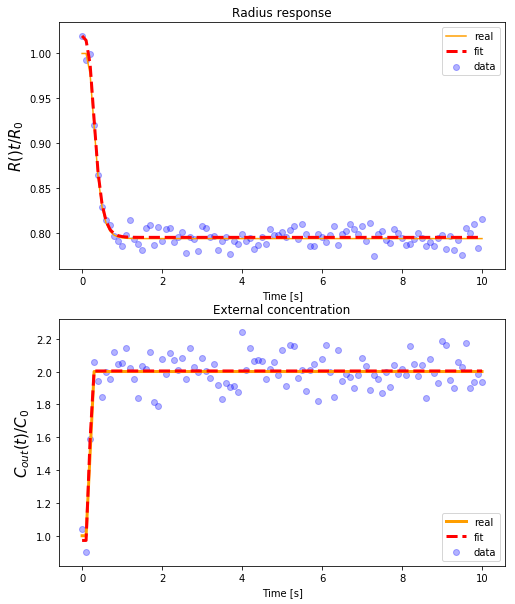

In [3]:
step_function = False

shock = 'hyper'

# Parameters
epsilon = 2e-3
tau = 1.

r0 = 1.
t = np.linspace(0., 10., 101)
t1, t2 = .1, .3

#cmin, cmax = 0.5, 1     # If hypo osmotic shock
cmin, cmax = 1, 2      # If hyper osmotic shock

# Real functions
r = odeint(model, r0, t, args = (epsilon, tau, ))
c_l =  np.array([c(t[i], t1, t2, cmin, cmax, step_function, shock) for i in range(len(t))])

# Noisy data
r_noisy = r[:,0] + np.random.normal(0, 0.01, size=(len(r)))
c_noisy = c_l + np.random.normal(0., 0.1, size=(len(r)))


### Evaluation
popt_c, pcov_c = curve_fit(sigmoide, t, c_noisy)
popt_r, pcov_r = curve_fit(fit_func, t, r_noisy)

print 'epsilon : \n  True value : '+str(epsilon) + ' ; estimated value : ' + str(popt_r[0])
print 'tau : \n  True value : '+str(tau) + ' ; estimated value : ' + str(popt_r[1])

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(t, r[:, 0], color = '#FF9E00', label = 'real')
ax[0].scatter(t, r_noisy, color = 'b', label = 'data', alpha=0.3)
ax[0].plot(t, fit_func(t, popt_r[0], popt_r[1]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[0].legend()
ax[0].set_title('Radius response')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r'$R()t / R_0$', fontsize=15)

ax[1].plot(t, c_l, color = '#FF9E00', label = 'real', linewidth = 3)
ax[1].scatter(t, c_noisy, color = 'b', label = 'data', alpha=0.3)
ax[1].plot(t, sigmoide(t, popt_c[0], popt_c[1], popt_c[2], popt_c[3]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[1].legend()
ax[1].set_title('External concentration')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel(r'$C_{out}(t) / C_0$', fontsize=15)
plt.show()

This is the closest case compared to your results for hyper osmotic shock. There are few values at the beggining, but the model still works pretty well. Of course, those are fake values, so it has to work since it is generated from a perfect model (no side effects).
Nevertheless, this ideal case shows how the fit and the evaluation work.

#### $\beta$ - Hypo osmotic shock

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp


epsilon : 
  True value : 0.002 ; estimated value : 0.0013672748250191814
tau : 
  True value : 1.0 ; estimated value : 1.0


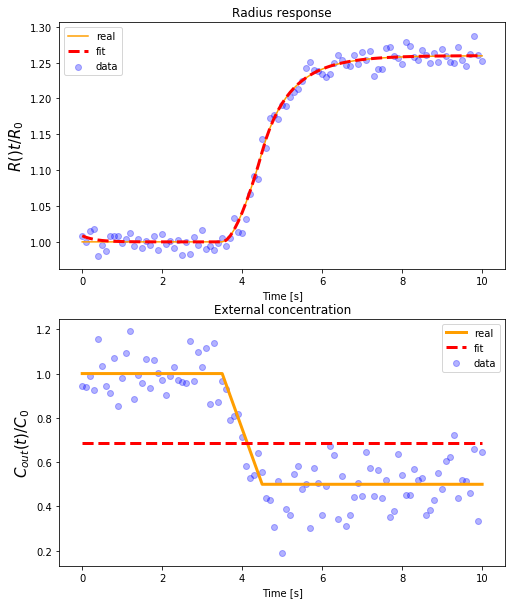

In [4]:
step_function = False

shock = 'hypo'

# Parameters
epsilon = 2e-3
tau = 1.

r0 = 1.
t = np.linspace(0., 10., 101)
t1, t2 = 3.5, 4.5

cmin, cmax = 0.5, 1     # If hypo osmotic shock
#cmin, cmax = 1, 2      # If hyper osmotic shock

# Real functions
r = odeint(model, r0, t, args = (epsilon, tau, ))
c_l =  np.array([c(t[i], t1, t2, cmin, cmax, step_function, shock) for i in range(len(t))])

# Noisy data
r_noisy = r[:,0] + np.random.normal(0, 0.01, size=(len(r)))
c_noisy = c_l + np.random.normal(0., 0.1, size=(len(r)))


### Evaluation
popt_c, pcov_c = curve_fit(sigmoide, t, c_noisy)
popt_r, pcov_r = curve_fit(fit_func, t, r_noisy)

print 'epsilon : \n  True value : '+str(epsilon) + ' ; estimated value : ' + str(popt_r[0])
print 'tau : \n  True value : '+str(tau) + ' ; estimated value : ' + str(popt_r[1])

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(t, r[:, 0], color = '#FF9E00', label = 'real')
ax[0].scatter(t, r_noisy, color = 'b', label = 'data', alpha=0.3)
ax[0].plot(t, fit_func(t, popt_r[0], popt_r[1]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[0].legend()
ax[0].set_title('Radius response')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r'$R()t / R_0$', fontsize=15)

ax[1].plot(t, c_l, color = '#FF9E00', label = 'real', linewidth = 3)
ax[1].scatter(t, c_noisy, color = 'b', label = 'data', alpha=0.3)
ax[1].plot(t, sigmoide(t, popt_c[0], popt_c[1], popt_c[2], popt_c[3]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[1].legend()
ax[1].set_title('External concentration')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel(r'$C_{out}(t) / C_0$', fontsize=15)
plt.show()

### ii - $c_{out}$ as a step function

Now, we test another model, less physical : we assume $c_{out}$ to be a step function.

#### $\alpha$ - Hyper osmotic shock

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp


epsilon : 
  True value : 0.002 ; estimated value : 0.6834185511497322
tau : 
  True value : 1.0 ; estimated value : 1.0


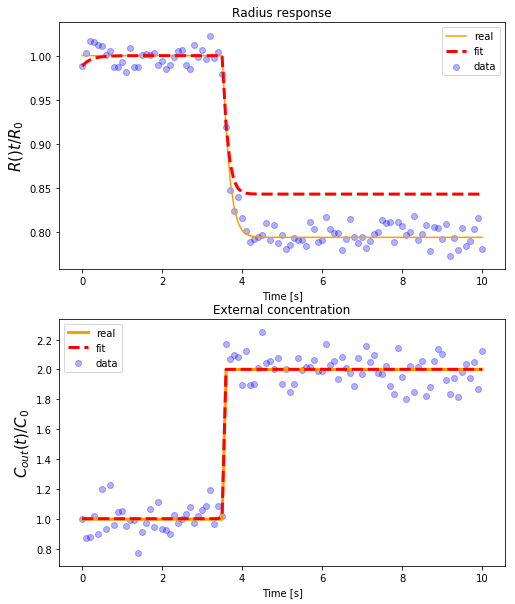

In [5]:
step_function = True
shock = 'hyper'

# Parameters
epsilon = 2e-3
tau = 1.

r0 = 1.
t = np.linspace(0., 10., 101)
t1, t2 = 3.5, 4.5

#cmin, cmax = 0.5, 1     # If hypo osmotic shock
cmin, cmax = 1, 2      # If hyper osmotic shock

# Real functions
r = odeint(model, r0, t, args = (epsilon, tau, ))
c_l =  np.array([c(t[i], t1, t2, cmin, cmax, step_function, shock) for i in range(len(t))])

# Noisy data
r_noisy = r[:,0] + np.random.normal(0, 0.01, size=(len(r)))
c_noisy = c_l + np.random.normal(0., 0.1, size=(len(r)))

### Evaluation
popt_c, pcov_c = curve_fit(sigmoide, t, c_noisy)
popt_r, pcov_r = curve_fit(fit_func, t, r_noisy)
print 'epsilon : \n  True value : '+str(epsilon) + ' ; estimated value : ' + str(popt_r[0])
print 'tau : \n  True value : '+str(tau) + ' ; estimated value : ' + str(popt_r[1])

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(t, r[:, 0], color = '#FF9E00', label = 'real')
ax[0].scatter(t, r_noisy, color = 'b', label = 'data', alpha=0.3)
ax[0].plot(t, fit_func(t, popt_r[0], popt_r[1]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[0].legend()
ax[0].set_title('Radius response')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r'$R()t / R_0$', fontsize=15)

ax[1].plot(t, c_l, color = '#FF9E00', label = 'real', linewidth = 3)
ax[1].scatter(t, c_noisy, color = 'b', label = 'data', alpha=0.3)
ax[1].plot(t, sigmoide(t, popt_c[0], popt_c[1], popt_c[2], popt_c[3]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[1].legend()
ax[1].set_title('External concentration')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel(r'$C_{out}(t) / C_0$', fontsize=15)
plt.show()

As you can see, the ramp function does not work quite well.

#### $\beta$ - Hypo osmotic shock

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp


epsilon : 
  True value : 0.002 ; estimated value : 0.4234224402347043
tau : 
  True value : 1.0 ; estimated value : 1.0


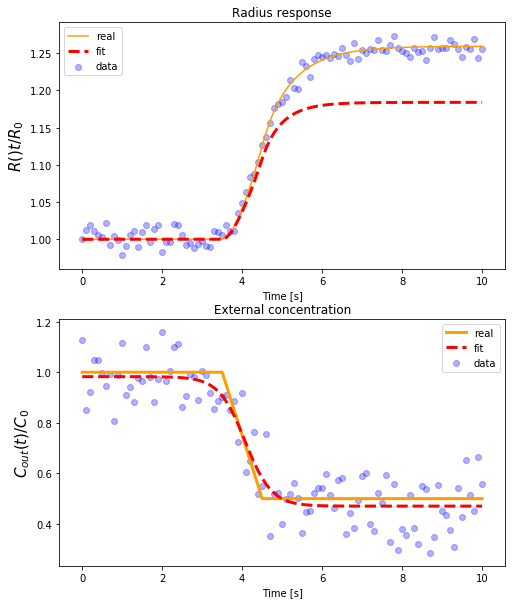

In [6]:
step_function = False
shock = 'hypo'

# Parameters
epsilon = 2e-3
tau = 1.

r0 = 1.
t = np.linspace(0., 10., 101)
t1, t2 = 3.5, 4.5

cmin, cmax = 0.5, 1     # If hypo osmotic shock
#cmin, cmax = 1, 2      # If hyper osmotic shock

# Real functions
r = odeint(model, r0, t, args = (epsilon, tau, ))
c_l =  np.array([c(t[i], t1, t2, cmin, cmax, step_function, shock) for i in range(len(t))])

# Noisy data
r_noisy = r[:,0] + np.random.normal(0, 0.01, size=(len(r)))
c_noisy = c_l + np.random.normal(0., 0.1, size=(len(r)))

### Evaluation
popt_c, pcov_c = curve_fit(sigmoide, t, c_noisy)
popt_r, pcov_r = curve_fit(fit_func, t, r_noisy)
print 'epsilon : \n  True value : '+str(epsilon) + ' ; estimated value : ' + str(popt_r[0])
print 'tau : \n  True value : '+str(tau) + ' ; estimated value : ' + str(popt_r[1])

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(t, r[:, 0], color = '#FF9E00', label = 'real')
ax[0].scatter(t, r_noisy, color = 'b', label = 'data', alpha=0.3)
ax[0].plot(t, fit_func(t, popt_r[0], popt_r[1]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[0].legend()
ax[0].set_title('Radius response')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(r'$R()t / R_0$', fontsize=15)

ax[1].plot(t, c_l, color = '#FF9E00', label = 'real', linewidth = 3)
ax[1].scatter(t, c_noisy, color = 'b', label = 'data', alpha=0.3)
ax[1].plot(t, sigmoide(t, popt_c[0], popt_c[1], popt_c[2], popt_c[3]), label = 'fit', color = 'r', linestyle='--', linewidth=3)
ax[1].legend()
ax[1].set_title('External concentration')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel(r'$C_{out}(t) / C_0$', fontsize=15)
plt.show()

## c. Real data

Now, this part does not work well...

In [7]:
def fit_data(filename, usecols=(0, 1, 8), shock = 'hypo') :
    """
    fit_data(filename, usecols=(0, 1, 8), shock = 'hypo')
    
        A function that should fits the data. Still needs to be fixed...
        
    """
    data = np.loadtxt(filename, delimiter=';')
    
    t_data, r_data, c_data = data[:, usecols[0]], data[:, usecols[1]], data[:, usecols[2]]
    
    popt_c, pcov_c = curve_fit(sigmoide, t_data, c_data)
    popt_r, pcov_r = curve_fit(fit_func, t_data, r_data)
    
    fig, ax = plt.subplots(1, 2, figsize= (10, 5))
    ax[0].scatter(t_data, r_data, alpha=0.3, color = 'b', label = 'Data')
    ax[0].plot(t_data, fit_func(t_data, popt_r[0], popt_r[1]), color = 'r', linewidth=3, label = 'Fit')
    ax[0].legend()
    ax[0].set_title('Radius response')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel(r'$R()t / R_0$', fontsize=15)
    
    ax[1].scatter(t_data, c_data, alpha=0.3, color = 'g', label = 'Data')
    ax[1].plot(t_data, sigmoide(t_data, popt_c[0], popt_c[1], popt_c[2], popt_c[3]), color = 'r', linewidth=3, label = 'Fit')
    ax[1].legend()
    ax[1].set_title('External concentration')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel(r'$C_{out}(t) / C_0$', fontsize=15)
    plt.show()

# Data

In [16]:
data = np.loadtxt('data1.csv', delimiter=';', skiprows=1)

Just to show how the fit on the concentration works

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp


[  0.825503     0.11957185   0.98242669 -50.41503683]
[-99.35098013   1.         101.26917423   1.        ]


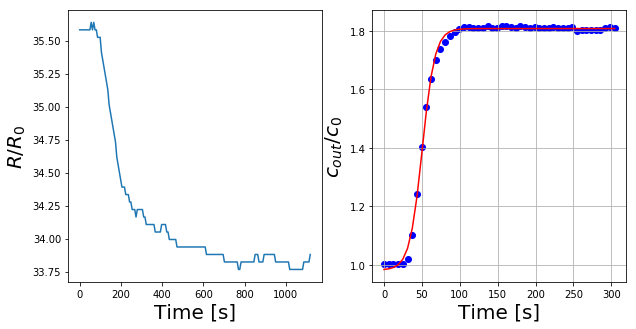

In [11]:
index1, index2 = 0, 8

start1, start2 = 0, 20
end1, end2 = 50, 500

p1, p1cov = curve_fit(sigmoide, data[start1:end1, index1], data[start1:end1, index2]+1)
print p1

p2, p2cov = curve_fit(sigmoide, data[start2:end2, index1], data[start2:end2, index2]+1)
print p2

fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].plot(data[:, 0], data[:, 3], label = 'Relative radius')
ax[0].set_xlabel('Time [s]', fontsize=20)
ax[0].set_ylabel('$R / R_0$', fontsize=20)

ax[1].scatter(data[start1:end1, index1], data[start1:end1, index2]+1, color = 'blue')
#ax[1].scatter(data[start2:end2, index1], data[start2:end2, index2]+1, color = 'orange')

ax[1].plot(data[start1:end1, index1], sigmoide(data[start1:end1, index1], p1[0], p1[1], p1[2], p1[3]), color='r')
#ax[1].plot(data[start2:end2, index1], sigmoide(data[start2:end2, index1], p2[0], p2[1], p2[2], p2[3]), color='g')

#ax[1].plot(data[:, 0], data[:, 13])
ax[1].set_xlabel('Time [s]', fontsize=20)
ax[1].set_ylabel(r'$c_{out} / c_0$', fontsize=20)
ax[1].grid()
#ax[1].legend()


In [12]:
p2, p2cov = curve_fit(sigmoide, data[start2:end2, index1], data[start2:end2, index2]+1)
print p2

[-99.35098013   1.         101.26917423   1.        ]


[-99.88944501   1.         100.80763911   1.        ]


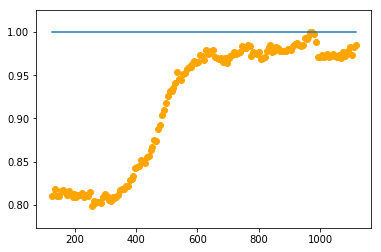

In [13]:
p2, p2cov = curve_fit(sigmoide, data[start2:end2, index1], data[start2:end2, index2])
print p2
plt.scatter(data[start2:end2, index1], data[start2:end2, index2], color = 'orange')
plt.plot(data[start2:end2, index1], sigmoide(data[start2:end2, index1], 1., 1., 0., 1.))#sigmoide(data[start2:end2, index1], p2[0], p2[1], p2[2], p2[3]), color='g')



/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp


[  0.43695034 -63.46670842   0.88801755  61.65190948]


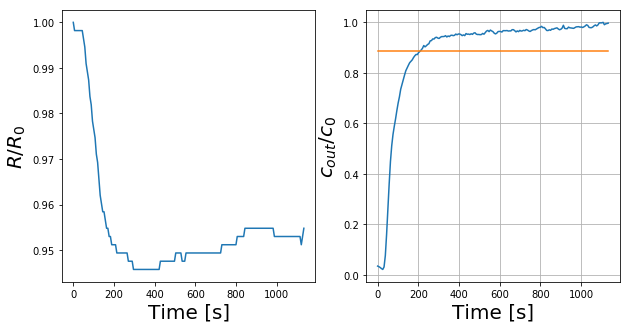

In [17]:
data2 = np.loadtxt('data2.csv', delimiter=';', skiprows=1)

popt_c, pcov_c = curve_fit(sigmoide, data2[:, 0], data2[:, 7])
print popt_c

fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax[0].plot(data2[:, 0], data2[:, 1], label = 'Relative radius')
ax[0].set_xlabel('Time [s]', fontsize=20)
ax[0].set_ylabel('$R / R_0$', fontsize=20)

ax[1].plot(data2[:, 0], data2[:, 7])
ax[1].plot(data2[:, 0], sigmoide(data2[:, 0], popt_c[0], popt_c[1], popt_c[2], popt_c[3]))
#ax[1].plot(data2[:, 0], data2[:, 13])
ax[1].set_xlabel('Time [s]', fontsize=20)
ax[1].set_ylabel(r'$c_{out} / c_0$', fontsize=20)
ax[1].grid()
#ax[1].legend()